In [1]:
#Import necessary libraries
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
# !pip install xgboost
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)

In [3]:
#Read in excel data
pass_modelling_data = pd.read_excel('C:\\Users\\kpaul\\Documents\\Univeristy of Glasgow - MSc\\Semester 4 - Fall 2024\\Final Year Project\\Project Code\\pass_data_modelling.xlsx')
pass_modelling_data.head()

#Categorical columns to convert using one hot encoding
categorical_cols = ['team_name', 'opposing_team', 'player_name',
       'poistion', 'play_pattern', 'pass_recipient', 'pass_height_name',
       'pass_body_part', 'pass_type', 'pass_technique']
pass_data_one_hot = pd.get_dummies(pass_modelling_data, columns=categorical_cols, drop_first=True)

#Convert time string to seconds
def time_to_seconds(time_col):
    minutes, seconds = map(int, time_col.split(':')) #spilt the time column where ':' occurs
    total_seconds = minutes * 60 + seconds
    return total_seconds

#Apply function to time column in dataframe
pass_data_one_hot['match_time_sec'] = pass_data_one_hot['time'].apply(time_to_seconds)

pass_data_one_hot.head()

,Unnamed: 0,match_id,time,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,...,pass_recipient_Stine Ballisager Pedersen,pass_recipient_Susan Banda,pass_recipient_Svenja Huth,pass_recipient_Sydney Lohmann,pass_recipient_Tahnai Lauren Rivera Annis,pass_recipient_Takako Seike,pass_recipient_Tameka Yallop,pass_recipient_Tamires Cássia Dias de Britto,pass_recipient_Tatiana Vanessa Ferreira Pinto,pass_recipient_Telma Raquel Velosa Encarnação,pass_recipient_Teresa Abelleira Dueñas,pass_recipient_Thea Bjelde,pass_recipient_Thembi Kgatlana,pass_recipient_Thu Thương Lương Thị,pass_recipient_Thu Thảo Trần Thị,pass_recipient_Thu Trần Thị,pass_recipient_Thị Diễm My Lê,pass_recipient_Thị Hải Linh Trần,pass_recipient_Thị Kiều Chương,pass_recipient_Thị Mỹ Anh Nguyễn,pass_recipient_Thị Thanh Nhã Nguyễn,pass_recipient_Thị Thảo Thái,pass_recipient_Thị Vân Dương,pass_recipient_Tiernny Arlene Wiltshire,pass_recipient_Tiffany Cameron,pass_recipient_Tiisetso Makhubela,pass_recipient_Trinity Rain Moyer-Rodman,pass_recipient_Trudi Sudan Carter,pass_recipient_Tuva Hansen,pass_recipient_Tuyết Dung Nguyễn Thị,pass_recipient_Uchenna Kanu,pass_recipient_Valentina Cernoia,pass_recipient_Valentina Giacinti,pass_recipient_Valeria del Campo Gutiérrez,pass_recipient_Vanessa Brigitte Gilles,pass_recipient_Vanina Noemí Correa,pass_recipient_Vast Phiri,pass_recipient_Vicki Becho,pass_recipient_Victoria Esson,pass_recipient_Victoria Pelova,pass_recipient_Vilde Bøe Risa,pass_recipient_Viola Calligaris,pass_recipient_Viviane Asseyi,pass_recipient_Vyan Sampson,pass_recipient_Vạn Sự Ngân Thị,pass_recipient_Wendie Renard,pass_recipient_Wendy Shongwe,pass_recipient_Wendy Yisbel Natis Bárcenas,pass_recipient_Wieke Hendrikje Maria Kaptein,pass_recipient_Xin Zhang,pass_recipient_Yamila Tamara Rodríguez,pass_recipient_Yao Wei,pass_recipient_Yasha Gu,pass_recipient_Yasmin Katie Mrabet,pass_recipient_Yenith Elizabett Bailey de la Cruz,pass_recipient_Yomira Tibisay Pinzón Ríos,pass_recipient_Young-Geul Yoon,pass_recipient_Young-Ju Lee,pass_recipient_Yu Zhu,pass_recipient_Yu-Ri Choe,pass_recipient_Yui Hasegawa,pass_recipient_Zecira Musovic,pass_recipient_Zineb Redouani,pass_recipient_Érica Noelia Lonigro,pass_height_name_High Pass,pass_height_name_Low Pass,pass_body_part_Left Foot,pass_body_part_No Touch,pass_body_part_Other,pass_body_part_Right Foot,pass_type_Kick Off,pass_type_Normal,pass_type_Recovery,pass_technique_Unknown,match_time_sec
0,0,3893787,0:00,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,0,0,0,0,0,1,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,0
1,1,3893787,0:01,1.8,52.8,37.1,0,34.1,62.5,31.5,2.2,0,0,0,0,0,1,1,34.1,48.9,1,35.3,35.2,1,37.7,64.5,1,43.6,19.6,1,49.8,45

In [9]:
np.random.seed(42)
random.seed(42)  

#Create training and test data
#X - removed columns not needed and drop the target column
X = pass_data_one_hot.drop(['pass_outcome','Unnamed: 0','time'],axis=1)
#y is the target column in data
y = pass_data_one_hot['pass_outcome']

#Split X and y into training and testing sets - 80/20, and use stratify to balance classes in spilt
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16, stratify=y)

print(X_test.shape)
print(y_test.shape)
print(X_train.shape)
print(y_train.shape)

(9250, 1354)
(9250,)
(36997, 1354)
(36997,)


In [11]:
# yval = pd.DataFrame(y_train)
# yval2 = pd.DataFrame(y_test)
# yval[yval['pass_outcome'] ==0] #train 1 = 27792, 0= 9205 (24.88%)
# yval2[yval2['pass_outcome'] ==1] #train 1 = 6948, 0= 2302 (24.88%)

,pass_outcome
30504,1
35916,1
1627,1
34425,1
27726,1
...,...
3095,1
41394,1
28024,1
981,1


In [33]:
np.random.seed(42)
random.seed(42)

#Create instance of RandomForestClassifer Model
rf = RandomForestClassifier()

#Create hyperparamters to tune
params = {
     'max_depth': randint(1,100),
     'min_samples_split' : randint(1,10),
     'n_estimators': randint(10,1000)
 }

#Start random search for the best hyperparameters
rf_search = RandomizedSearchCV(estimator=rf,
                            param_distributions=params,
                            n_jobs=-1, verbose=1, scoring="accuracy")

#Fit the search to the training data
rf_model = rf_search.fit(X_train, y_train)

#Use the best parameters
rf_best = rf_model.best_estimator_
print(rf_best)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(max_depth=76, min_samples_split=6, n_estimators=262)


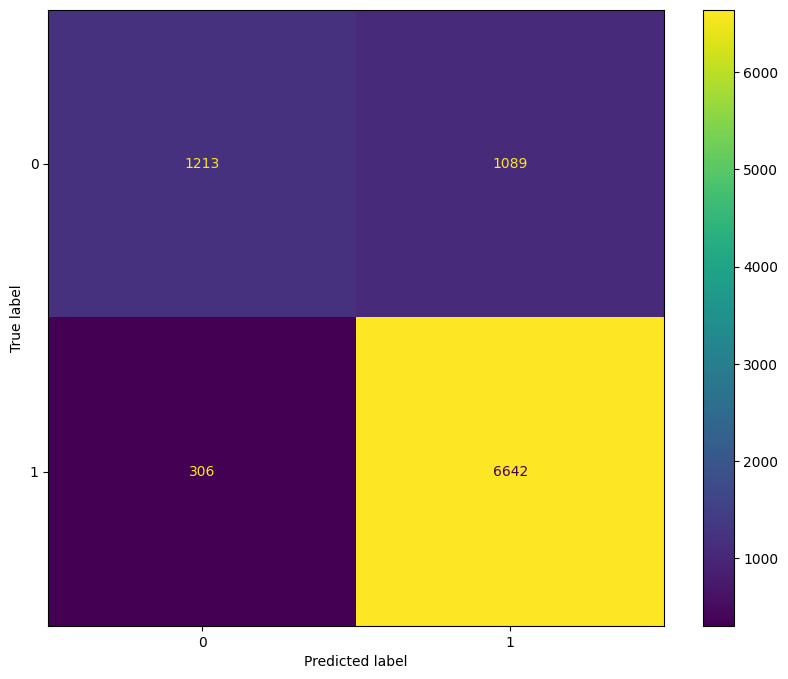

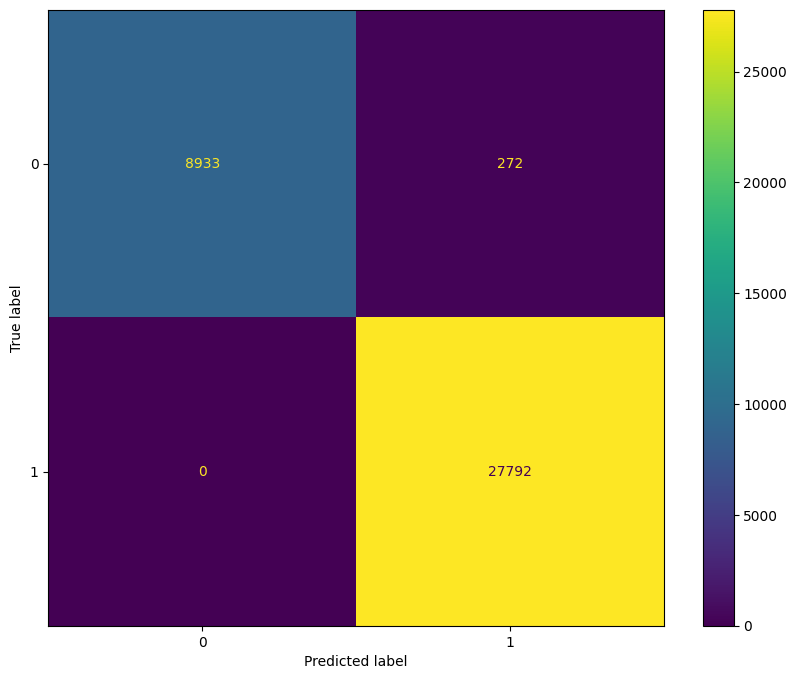

In [34]:
#Predict on test data using best model
y_pred_test = rf_best.predict(X_test)
y_pred_train = rf_best.predict(X_train)

#Create confusion matrix to assess the true label vs predicted label for train and test
cm_test = confusion_matrix(y_test, y_pred_test)
cm_train = confusion_matrix(y_train, y_pred_train)

ConfusionMatrixDisplay(confusion_matrix=cm_test).plot();
ConfusionMatrixDisplay(confusion_matrix=cm_train).plot();

In [35]:
#Calculate accuracy of model on test and train data
test_accuracy_rf = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {test_accuracy_rf:.4f}')

train_accuracy_rf = accuracy_score(y_train, y_pred_train)
print(f'Training Accuracy: {train_accuracy_rf:.4f}')

Test Accuracy: 0.8492
Training Accuracy: 0.9926


In [36]:
# #Calculate precision and recall of model for test and train
# precision_test = precision_score(y_test, y_pred_test)
# recall_test = recall_score(y_test, y_pred_test)

# precision_train = precision_score(y_train, y_pred_train)
# recall_train = recall_score(y_train, y_pred_train)

# print("Precision (test) of RF model:", round(precision_test,3))
# print("Recall (test) of RF model:", round(recall_test,3))
# print("Precision (train) of RF model:", round(precision_train,3))
# print("Recall (train) of RF model:", round(recall_train,3))

Precision (test) of RF model: 0.859
Recall (test) of RF model: 0.956
Precision (train) of RF model: 0.99
Recall (train) of RF model: 1.0


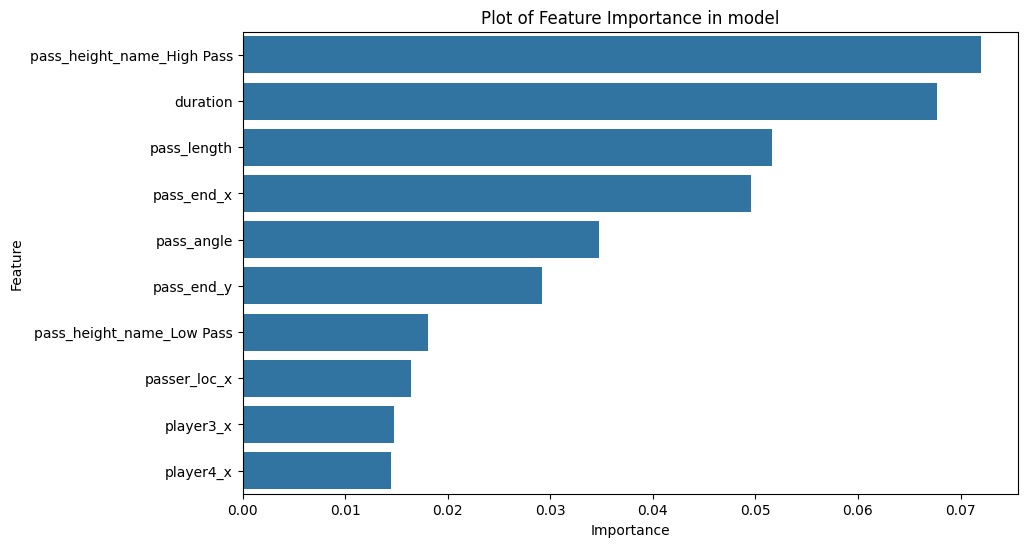

In [38]:
#Get feature importances
feature_importances = rf_best.feature_importances_

#Create a DataFrame to use for plotting
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

#Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)
#Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Plot of Feature Importance in model')
plt.show()

In [6]:
#Create new training and test data using key columns from RF model
#X created to use only key columns
X_rf_tuned = pass_data_one_hot[['pass_height_name_High Pass','duration','pass_length', 'pass_end_x', 'pass_angle',
                                                'pass_end_y', 'pass_height_name_Low Pass', 'passer_loc_x', 'player3_x', 'player4_x']]
#y is the target column in data
y_rf_tuned = pass_data_one_hot['pass_outcome']

#Split X and y into training and testing sets - 80/20
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf_tuned, y_rf_tuned, test_size=0.2, random_state=16, stratify=y_rf_tuned)

In [7]:
#Create instance of RandomForestClassifer Model
rf_1 = RandomForestClassifier()

#Create hyperparamters to tune
params_1 = {
     'max_depth': randint(1,100),
     'min_samples_split' : randint(1,10),
     'n_estimators': randint(10,1000)
 }

#Start random search for the best hyperparameters
rf_search_1 = RandomizedSearchCV(estimator=rf_1,
                            param_distributions=params_1,
                            n_jobs=-1, verbose=1, scoring="accuracy")

#Fit the search to the training data
rf_model_1 = rf_search_1.fit(X_train_rf, y_train_rf)

#Use the best parameters
rf_best_1 = rf_model_1.best_estimator_
print(rf_best_1)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestClassifier(max_depth=13, min_samples_split=4, n_estimators=249)


In [8]:
#Predict on test data using best model
y_pred_test_1 = rf_best_1.predict(X_test_rf)
y_pred_train_1 = rf_best_1.predict(X_train_rf)

#Calculate accuracy of model on test and train data
test_accuracy_rf_1 = accuracy_score(y_test_rf, y_pred_test_1)
print(f'Test Accuracy: {test_accuracy_rf_1:.4f}')
train_accuracy_rf_1 = accuracy_score(y_train_rf, y_pred_train_1)
print(f'Training Accuracy: {train_accuracy_rf_1:.4f}')

Test Accuracy: 0.8587
Training Accuracy: 0.8981


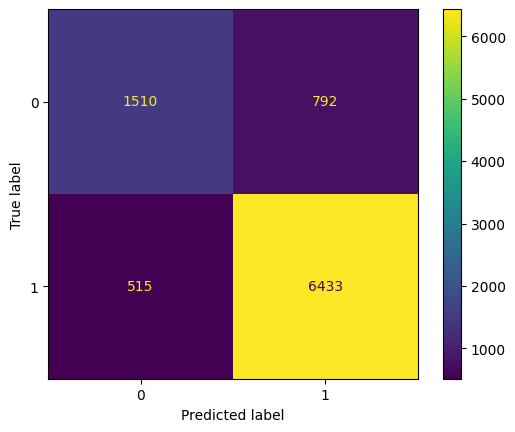

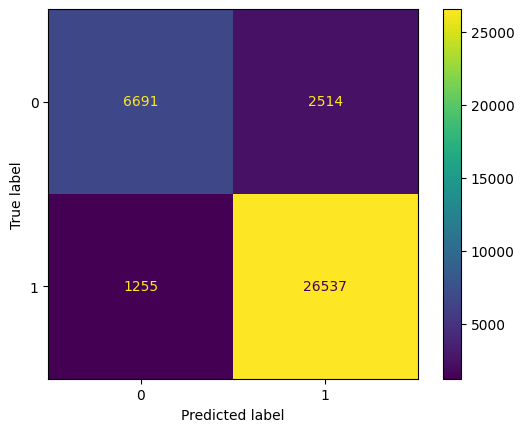

In [9]:
#Create confusion matrix to assess the true label vs predicted label for train and test
cm_test_rf_1 = confusion_matrix(y_test_rf, y_pred_test_1)
cm_train_rf_1 = confusion_matrix(y_train_rf, y_pred_train_1)

ConfusionMatrixDisplay(confusion_matrix=cm_test_rf_1).plot();
ConfusionMatrixDisplay(confusion_matrix=cm_train_rf_1).plot();

In [11]:
#Precision and Recall for test and train sets
precision_test_1 = precision_score(y_test_rf, y_pred_test_1)
recall_test_1 = recall_score(y_test_rf, y_pred_test_1)
precision_train_1 = precision_score(y_train_rf, y_pred_train_1)
recall_train_1 = recall_score(y_train_rf, y_pred_train_1)

#F1 score for test and train sets
f1_test_1 = f1_score(y_test_rf, y_pred_test_1)
f1_train_1 = f1_score(y_train_rf, y_pred_train_1)

# Print all the metrics
print("Precision (test) of RF model:", round(precision_test_1, 3))
print("Recall (test) of RF model:", round(recall_test_1, 3))
print("F1 Score (test) of RF model:", round(f1_test_1, 3))
print("Precision (train) of RF model:", round(precision_train_1, 3))
print("Recall (train) of RF model:", round(recall_train_1, 3))
print("F1 Score (train) of RF model:", round(f1_train_1, 3))


Precision (test) of RF model: 0.89
Recall (test) of RF model: 0.926
F1 Score (test) of RF model: 0.908
Precision (train) of RF model: 0.913
Recall (train) of RF model: 0.955
F1 Score (train) of RF model: 0.934


In [ ]:
#Move onto XG model creation now

In [14]:
np.random.seed(42)
random.seed(42)

#Declare variables for XG Model
param_grid = {
    'max_depth': [5,6,7,8],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.5, 0.7, 1]
}

#Create an instance of XGBClassifier to use in search for best hyperparameters
xg_b = xgb.XGBClassifier(objective = 'binary:logistic')
#Use GridSearchCV to search for the best hyperparameters using the choices from param_grid
grid_search = GridSearchCV(xg_b, param_grid, scoring='accuracy')
#Fit the grid result to the training data
grid_search.fit(X_train, y_train)

#Best hyperparameters
print("Best set of hyperparameters: ", grid_search.best_params_)
xgb_model = grid_search.best_estimator_

Best set of hyperparameters:  {'learning_rate': 0.1, 'max_depth': 7, 'subsample': 0.7}


In [16]:
#Use the model to predict on the test dataset
y_pred_test_xg = xgb_model.predict(X_test)
y_pred_train_xg = xgb_model.predict(X_train)

#Check accuracy score
print("XGBoost test accuracy score:", round(accuracy_score(y_test, y_pred_test_xg),3))
print("XGBoost train accuracy score:", round(accuracy_score(y_train, y_pred_train_xg),3))

#Compute precision and recall model scores for test and train datasets 
precision_test_xg = precision_score(y_test, y_pred_test_xg)
recall_test_xg = recall_score(y_test, y_pred_test_xg)
precision_train_xg = precision_score(y_train, y_pred_train_xg)
recall_train_xg = recall_score(y_train, y_pred_train_xg)
f1_test_xg = f1_score(y_test, y_pred_test_xg)
f1_train_xg = f1_score(y_train, y_pred_train_xg)

print("Precision of XG model (test):", round(precision_test_xg,3))
print("Recall of XG model (test):", round(recall_test_xg,3))
print("Precision of XG model (train):", round(precision_train_xg,3))
print("Recall of XG model(train):", round(recall_train_xg,3))
print("F1 Score of XG model (train):", round(f1_train_xg,3))
print("F1 Score of XG model(test):", round(f1_test_xg,3))

XGBoost test accuracy score: 0.873
XGBoost train accuracy score: 0.901
Precision of XG model (test): 0.904
Recall of XG model (test): 0.931
Precision of XG model (train): 0.92
Recall of XG model(train): 0.951
F1 Score of XG model (train): 0.935
F1 Score of XG model(test): 0.917


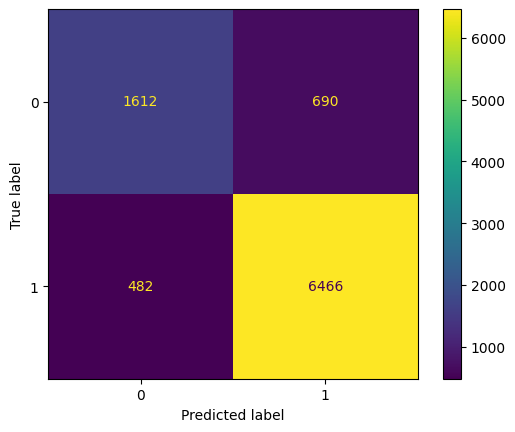

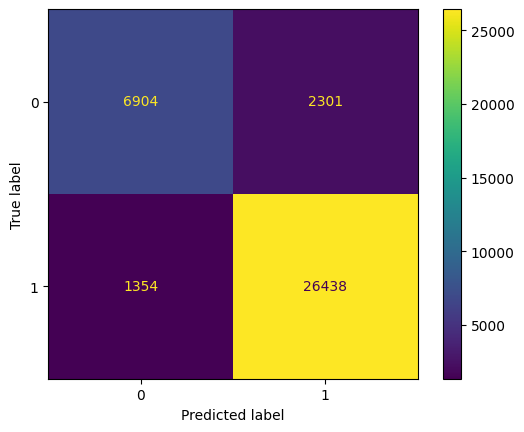

In [17]:
#Create confusion matrix to assess the true label vs predicted label for train and test
cm_test_xg = confusion_matrix(y_test, y_pred_test_xg)
cm_train_xg = confusion_matrix(y_train, y_pred_train_xg)

ConfusionMatrixDisplay(confusion_matrix=cm_test_xg).plot();
ConfusionMatrixDisplay(confusion_matrix=cm_train_xg).plot();

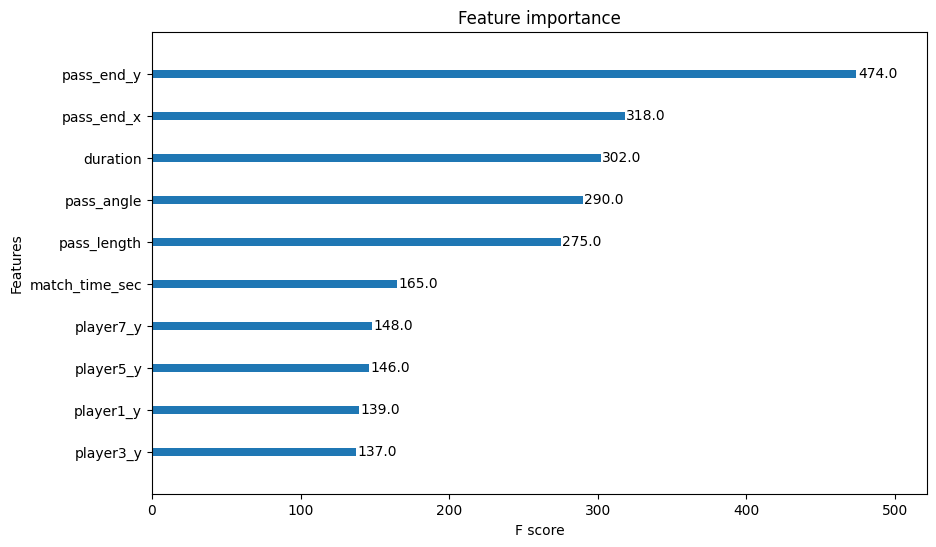

In [46]:
#Plot feature importance using the best model
best_model = xgb_model.get_booster()  #Get the booster from the model
plot_importance(xgb_model, max_num_features=10) #Plot top 10

plt.grid(False)
plt.rcParams['figure.figsize'] = [8,6]
plt.show()


In [50]:
#Get the predicted probabilities for the whole data set
probs_xg = xgb_model.predict_proba(X)

# #Display probabilities for each row (for both classes)
# pd.DataFrame(probs_xg).head(10)

#Get the probability a pass is completed for each pass
probability_df = pd.DataFrame(probs_xg[:, 1])
# probability_df .head()
# print("Probabilities:", probability_df)
probability_df .columns = ['complete_prob']
pass_modelling_data['complete_prob'] = probability_df ['complete_prob']
# pass_modelling_data.head()

#Create new excel with added column to be used in SNA
pass_modelling_data.to_excel("C:\\Users\\kpaul\\Documents\\Univeristy of Glasgow - MSc\\Semester 4 - Fall 2024\\Final Year Project\\Project Code\\sna_data_v1.xlsx") 